In [164]:
import numpy as np #math tools
import pandas as pd # data processing
import seaborn as sns;sns.set_style("darkgrid");sns.set_context("paper")
import matplotlib.pyplot as plt

#Stats tools
from scipy.stats import skew
from scipy.special import boxcox1p
from sklearn.preprocessing import StandardScaler

#More Basic ML models
import sklearn.linear_model as linear_model
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error

#Complexity ML models
import xgboost as xgb
import lightgbm as lightgbm

#To the annoying warnings XD
import warnings
warnings.filterwarnings('ignore')


In [165]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [166]:
#Checking for Missing Values¶
def missing_values(df):
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) !=0]
    total2 = total[total != 0 ]
    percent = round(df.isnull().sum().sort_values(ascending = False) / len(df) * 100, 2)
    percent2 = percent[percent !=0]
    
    #Deleting
    
    del(total)
    del(percent)
    #Returning the results
    return pd.concat([total2, percent2], axis = 1, keys = ['Total', 'Percent'])
    

In [167]:
missing_values(train)

,Total,Percent
PoolQC,1453,99.52
MiscFeature,1406,96.30
Alley,1369,93.77
Fence,1179,80.75
FireplaceQu,690,47.26
LotFrontage,259,17.74
GarageYrBlt,81,5.55
GarageCond,81,5.55
GarageType,81,5.55
GarageFinish,81,5.55


In [168]:
#Data Observation
def plotting_3_chart(df, feature):
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')
    
    fig = plt.figure(constrained_layout = True, figsize = (15,10))
    #Making the grid using the GridSpec function
    grid = gridspec.GridSpec(ncols = 3, nrows = 3, figure = fig)
    
    #Customizing the histogram
    ax1 = fig.add_subplot(grid[0,0:2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:,feature], kde = False, ax = ax1)
    
    #Customizing the QQ_plot
    ax2 = fig.add_subplot(grid[1,0:2])
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)
    
    #Customizing the Boxplot
    ax3 = fig.add_subplot(grid[0:2,2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3);  

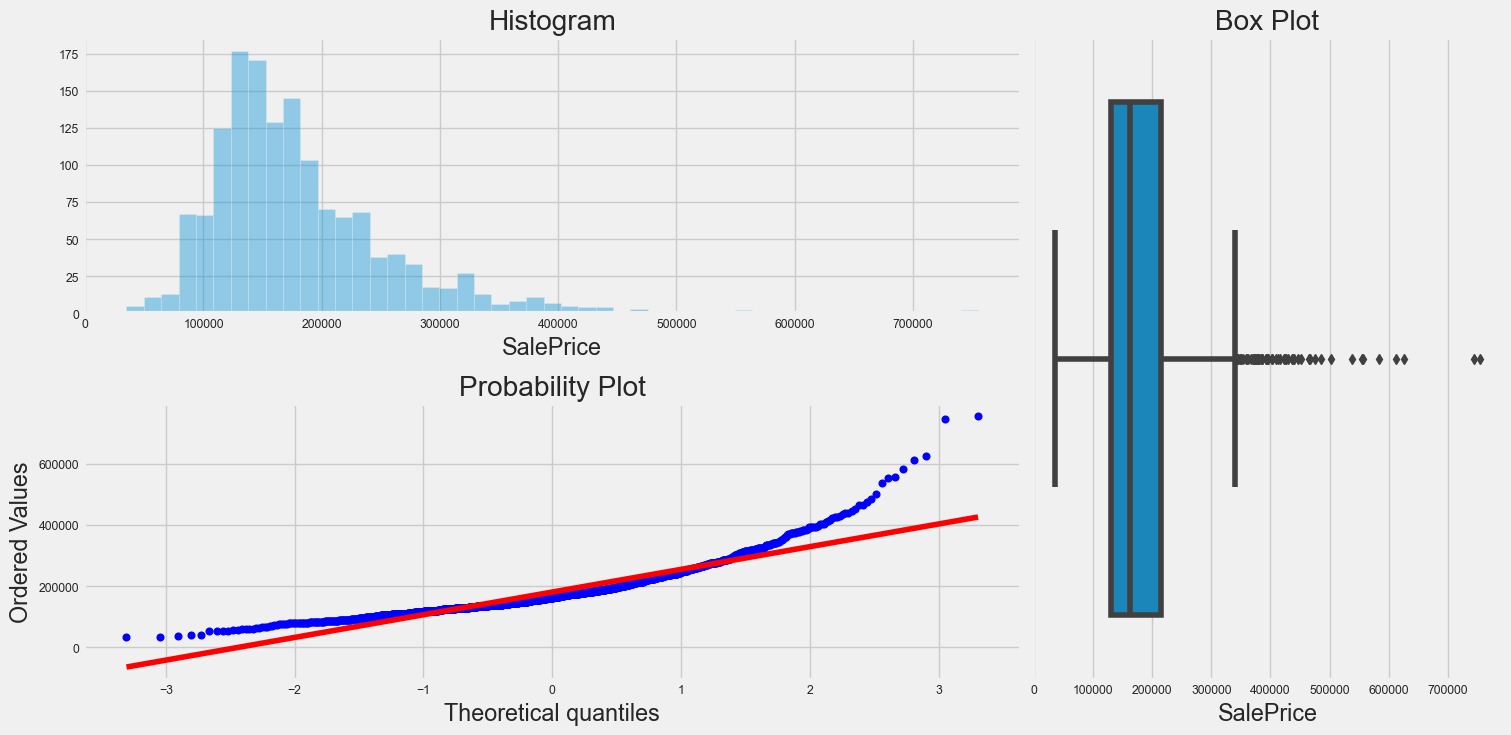

In [169]:
plotting_3_chart(train, 'SalePrice')

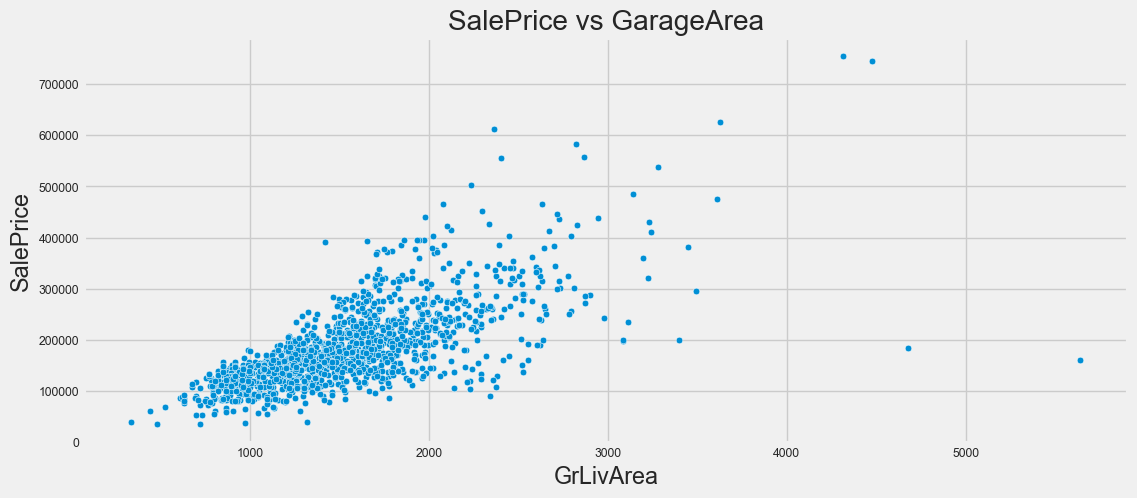

In [170]:
#SalePrice vs GarageArea
plt.figure(figsize = (12,5))
sns.scatterplot(x = 'GrLivArea', y = 'SalePrice', data = train)
plt.title('SalePrice vs GarageArea')
plt.show()

<Figure size 2000x1000 with 0 Axes>

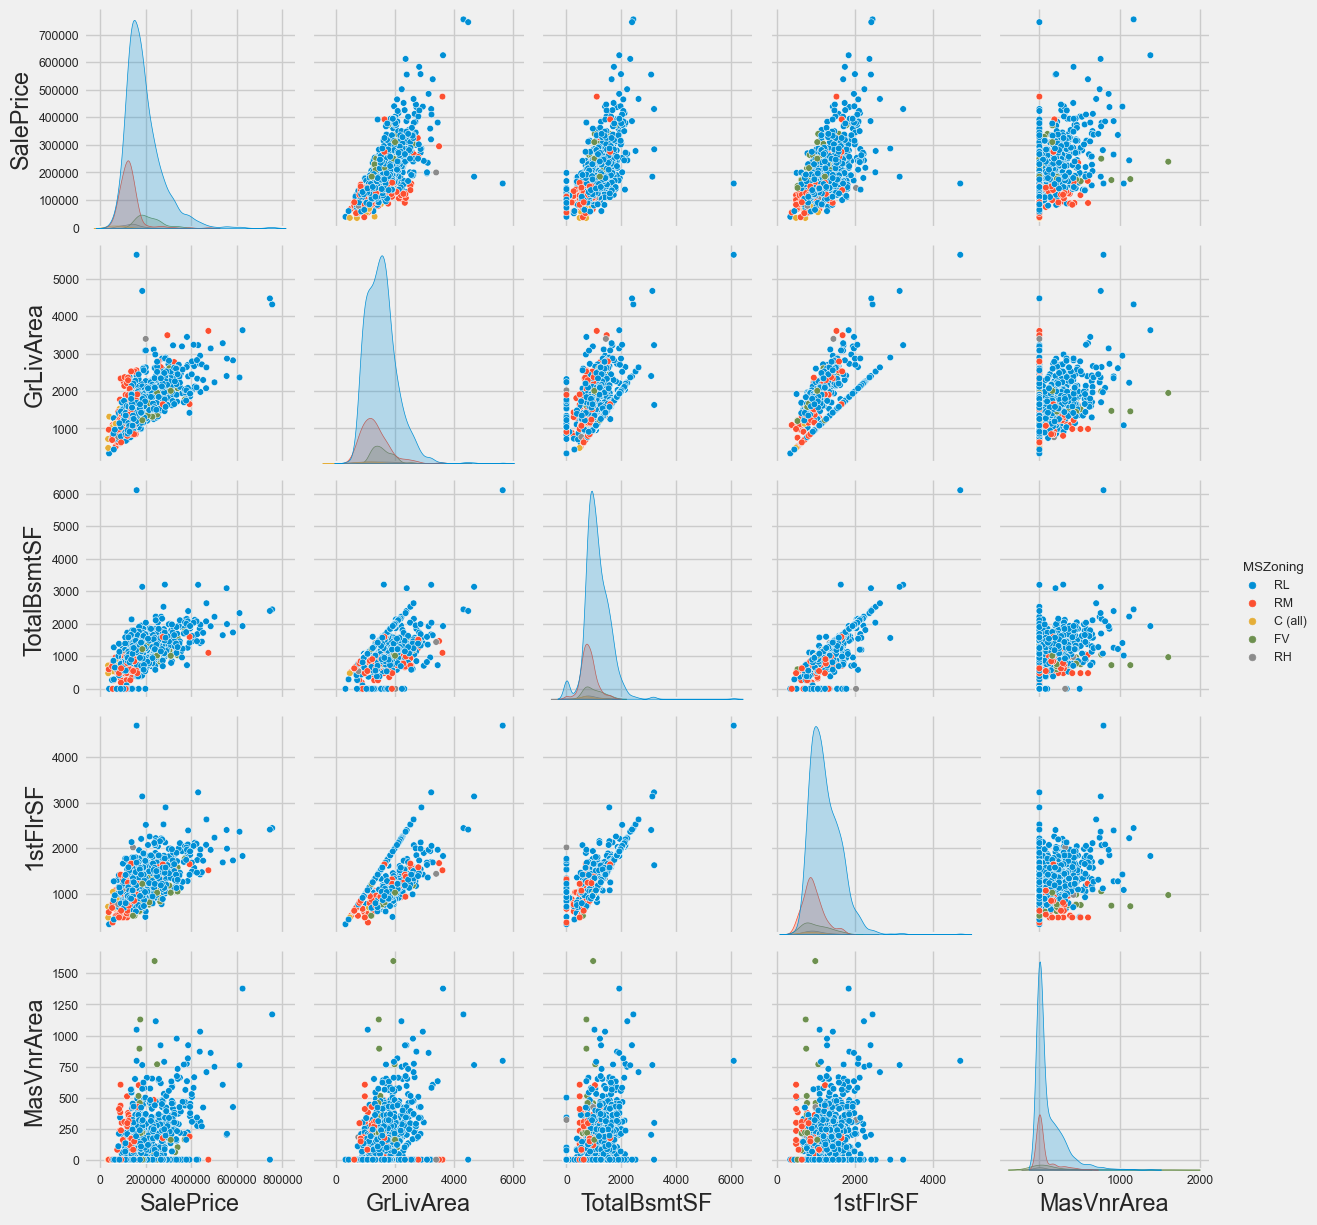

In [171]:
# Or we can do that, its more simple
features = ['SalePrice','GrLivArea', 'TotalBsmtSF' ,'1stFlrSF', 'MasVnrArea', 'MSZoning', 'KitchenQual']
dist_data = train[features]

plt.figure(figsize = (20,10))
sns.pairplot(data = dist_data, hue = 'MSZoning')
plt.show()

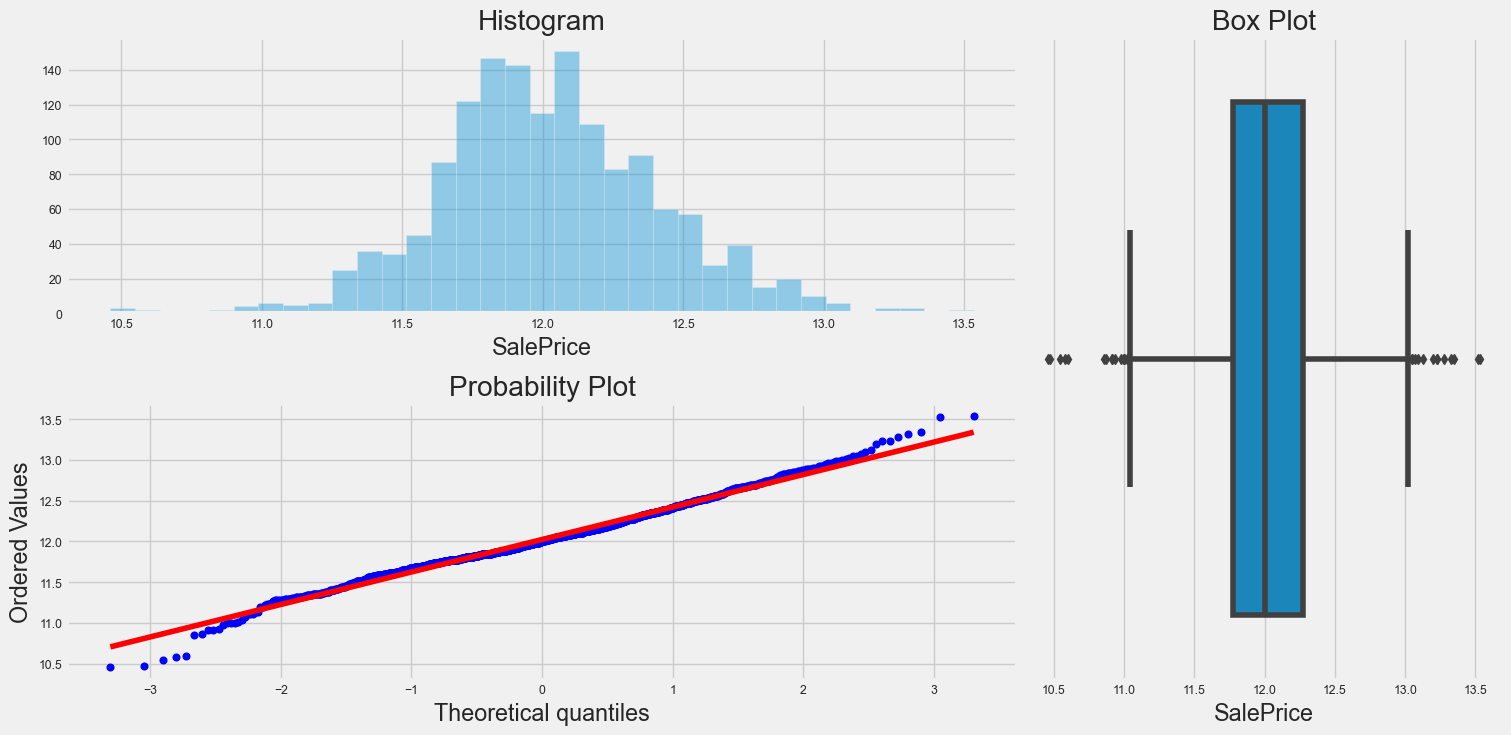

In [172]:
## trainsforming target variable using numpy.log1p, 
train["SalePrice"] = np.log1p(train["SalePrice"])

plotting_3_chart(train, 'SalePrice')

In [173]:
# Working with NA values in my df

train.drop(columns=['Id'],axis=1, inplace=True)
test.drop(columns=['Id'],axis=1, inplace=True)

## Saving the target values in "y_train". 
y = train['SalePrice'].reset_index(drop=True)



# getting a copy of train
previous_train = train.copy()

all_data = pd.concat((train, test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)



In [174]:
missing_values(all_data)

,Total,Percent
PoolQC,2909,99.66
MiscFeature,2814,96.40
Alley,2721,93.22
Fence,2348,80.44
FireplaceQu,1420,48.65
LotFrontage,486,16.65
GarageYrBlt,159,5.45
GarageFinish,159,5.45
GarageQual,159,5.45
GarageCond,159,5.45


In [175]:
#Imputing Missing values
#These features are non continous variable, we used "none" to replace the null values. 
missing_val_col = ["Alley", 
                   "PoolQC", 
                   "MiscFeature",
                   "Fence",
                   "FireplaceQu",
                   "GarageType",
                   "GarageFinish",
                   "GarageQual",
                   "GarageCond",
                   'BsmtQual',
                   'BsmtCond',
                   'BsmtExposure',
                   'BsmtFinType1',
                   'BsmtFinType2',
                   'MasVnrType']

for i in missing_val_col:
    all_data[i] = all_data[i].fillna('None')

In [176]:
## These features are continous variable, we used "0" to replace the null values. 
missing_val_col2 = ['BsmtFinSF1',
                    'BsmtFinSF2',
                    'BsmtUnfSF',
                    'TotalBsmtSF',
                    'BsmtFullBath', 
                    'BsmtHalfBath', 
                    'GarageYrBlt',
                    'GarageArea',
                    'GarageCars',
                    'MasVnrArea']

for i in missing_val_col2:
    all_data[i] = all_data[i].fillna(0)

In [177]:
# Working with the rest variables
missing_values(all_data)

,Total,Percent
LotFrontage,486,16.65
MSZoning,4,0.14
Utilities,2,0.07
Functional,2,0.07
Electrical,1,0.03
KitchenQual,1,0.03
Exterior2nd,1,0.03
Exterior1st,1,0.03
SaleType,1,0.03


In [178]:
## Replaced all missing values in LotFrontage by imputing the median value of each neighborhood. 
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform( lambda x: x.fillna(x.median()))

#Changing the type of the some variables
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str) 

#Adding values to the missing values present to this features 
all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0]) 
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [179]:
# Let me see what variables rest
missing_values(all_data)

,Total,Percent
Functional,2,0.07
Utilities,2,0.07
Electrical,1,0.03
KitchenQual,1,0.03


<AxesSubplot:title={'center':'Electrical'}, xlabel='Electrical', ylabel='count'>

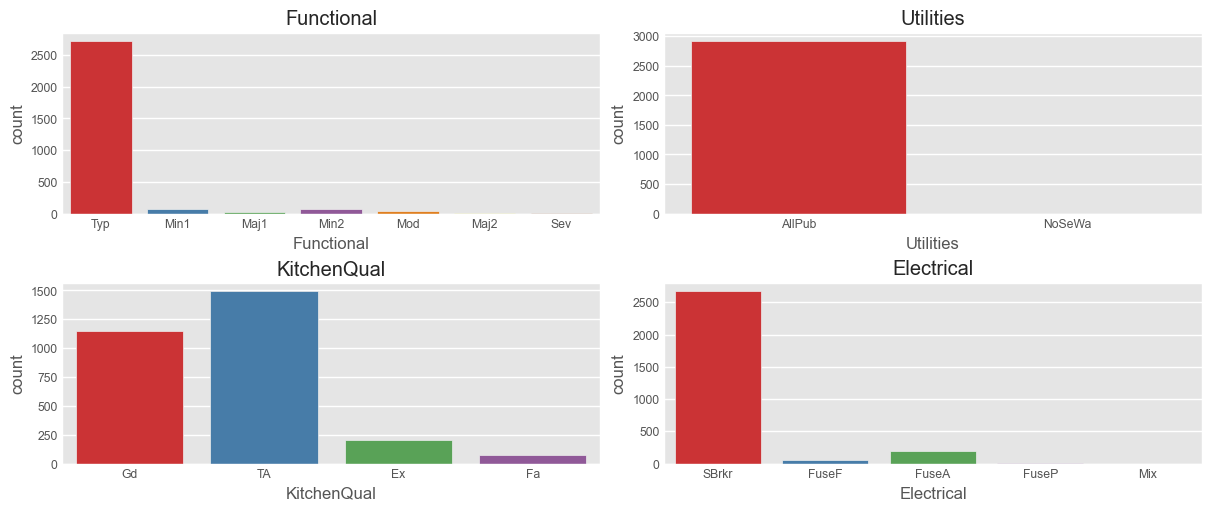

In [180]:
# Let we see those categorical variables

import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style
style.use('ggplot')
    
fig = plt.figure(constrained_layout = True, figsize = (12,5))
#Making the grid using the GridSpec function
grid = gridspec.GridSpec(ncols = 2, nrows = 2, figure = fig)
    
#First Countplot
ax1 = fig.add_subplot(grid[0,0])
ax1.set_title('Functional')
sns.countplot(all_data['Functional'], ax=ax1, palette='Set1')
    
#Second Countplot
ax2 = fig.add_subplot(grid[0,1])
ax2.set_title('Utilities')
sns.countplot(all_data['Utilities'], ax=ax2, palette='Set1')
    
#Third Countplot
ax3 = fig.add_subplot(grid[1,0])
ax3.set_title('KitchenQual')
sns.countplot(all_data['KitchenQual'], ax=ax3, palette='Set1')

#Fourth Countplot
ax4 = fig.add_subplot(grid[1,1])
ax4.set_title('Electrical')
sns.countplot(all_data['Electrical'], ax=ax4, palette='Set1')



In [181]:
all_data['Functional'] = all_data['Functional'].fillna('Typ') 
all_data['Utilities'] = all_data['Utilities'].fillna('AllPub') 
all_data['KitchenQual'] = all_data['KitchenQual'].fillna("TA") 
all_data['Electrical'] = all_data['Electrical'].fillna("SBrkr")

In [182]:
#Checking Again the MissingValues
missing_values(all_data)

,Total,Percent


In [183]:
#Checking the skewness
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_feats

MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
LotFrontage       1.505704
1stFlrSF          1.469604
BsmtFinSF1        1.425230
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
FullBath          0.167606
GarageCars       -0.219581
YearRemodAdd     -0.451020
YearBuilt        -0.599806
GarageYrBlt      -3.906205
dtype: float64

In [184]:
    def fixing_skewness(df):
        """
        This function takes in a dataframe and return fixed skewed dataframe
        """
        ## Import necessary modules 
        from scipy.stats import skew
        from scipy.special import boxcox1p
        from scipy.stats import boxcox_normmax

        ## Getting all the data that are not of "object" type. 
        numeric_feats = df.dtypes[df.dtypes != "object"].index

        # Check the skew of all numerical features
        skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
        high_skew = skewed_feats[abs(skewed_feats) > 0.5]
        skewed_features = high_skew.index

        for feat in skewed_features:
            df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))


In [185]:
#Make a copy of the df just to do some comparassing later
all_data_old = all_data.copy()

fixing_skewness(all_data)

<AxesSubplot:title={'center':'Density of 1stFlrSF without the transformation'}, xlabel='1stFlrSF', ylabel='Density'>

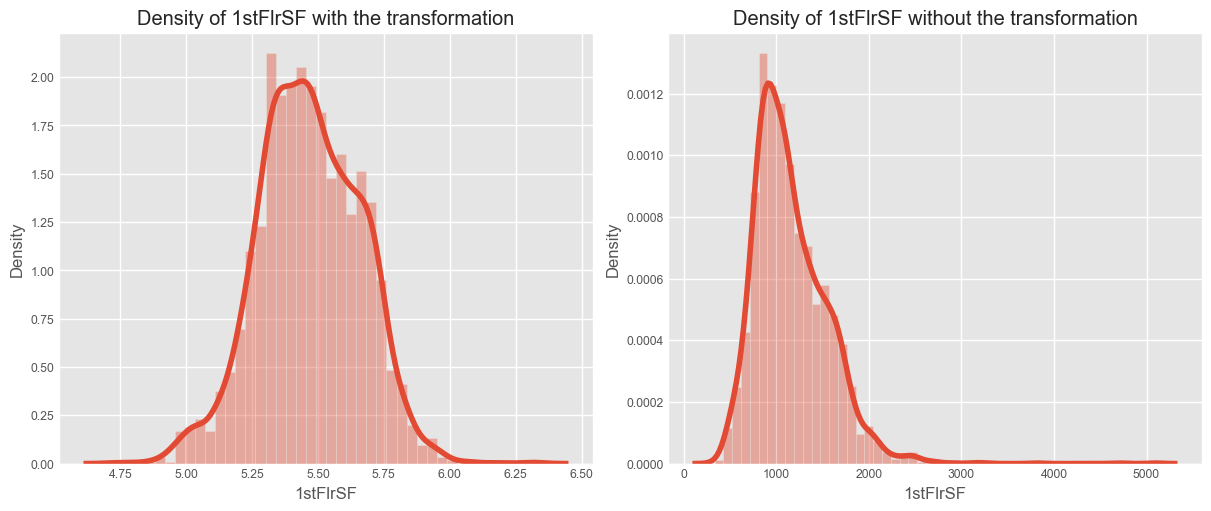

In [186]:
# Make the comparassing
import matplotlib.gridspec as gridspec
from scipy import stats
import matplotlib.style as style
style.use('ggplot')
    
fig = plt.figure(constrained_layout = True, figsize = (12,5))
#Making the grid using the GridSpec function
grid = gridspec.GridSpec(ncols = 2, nrows = 1, figure = fig)
    
#First Countplot
ax1 = fig.add_subplot(grid[0,0])
ax1.set_title('Density of 1stFlrSF with the transformation')
sns.distplot(all_data['1stFlrSF'], ax=ax1)
    
#Second Countplot
ax2 = fig.add_subplot(grid[0,1])
ax2.set_title('Density of 1stFlrSF without the transformation')
sns.distplot(all_data_old['1stFlrSF'], ax=ax2)



In [187]:
#Creating new variables

all_data = all_data.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

# feature engineering a new feature "TotalFS"
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['YrBltAndRemod']=all_data['YearBuilt']+all_data['YearRemodAdd']

all_data['Total_sqr_footage'] = (all_data['BsmtFinSF1'] + all_data['BsmtFinSF2'] +
                                 all_data['1stFlrSF'] + all_data['2ndFlrSF'])

all_data['Total_Bathrooms'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                               all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

all_data['Total_porch_sf'] = (all_data['OpenPorchSF'] + all_data['3SsnPorch'] +
                              all_data['EnclosedPorch'] + all_data['ScreenPorch'] +
                              all_data['WoodDeckSF'])

In [188]:
all_data['haspool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['has2ndfloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasgarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasbsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
all_data['hasfireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [189]:
#Creating Dummmy Variables
final_features = pd.get_dummies(all_data).reset_index(drop=True)
final_features.shape

(2919, 329)

In [190]:
#Separing then, the X data is gonna be use to test the models
X = final_features.iloc[:len(y), :]

X_sub = final_features.iloc[len(y):, :]

In [191]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])

In [192]:
def overfit_reducer(df):
    """
    This function takes in a dataframe and returns a list of features that are overfitted.
    """
    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.94:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

overfitted_features = overfit_reducer(X)

X = X.drop(overfitted_features, axis=1)
X_sub = X_sub.drop(overfitted_features, axis=1)

In [193]:
X.shape,y.shape, X_sub.shape

((1455, 328), (1455,), (1459, 328))

In [194]:
#Fitting model(simple approach)

from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = .33, random_state = 0)


X_train.shape, y_train.shape, X_test.shape, y_test.shape


((974, 328), (974,), (481, 328), (481,))

In [195]:
## importing necessary models.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Call in the LinearRegression object
lin_reg = LinearRegression(normalize=True, n_jobs=-1)
## fit train and test data. 
lin_reg.fit(X_train, y_train)
## Predict test data. 
y_pred = lin_reg.predict(X_test)


print ('%.2f'%mean_squared_error(y_test, y_pred))

43153615351674134528.00


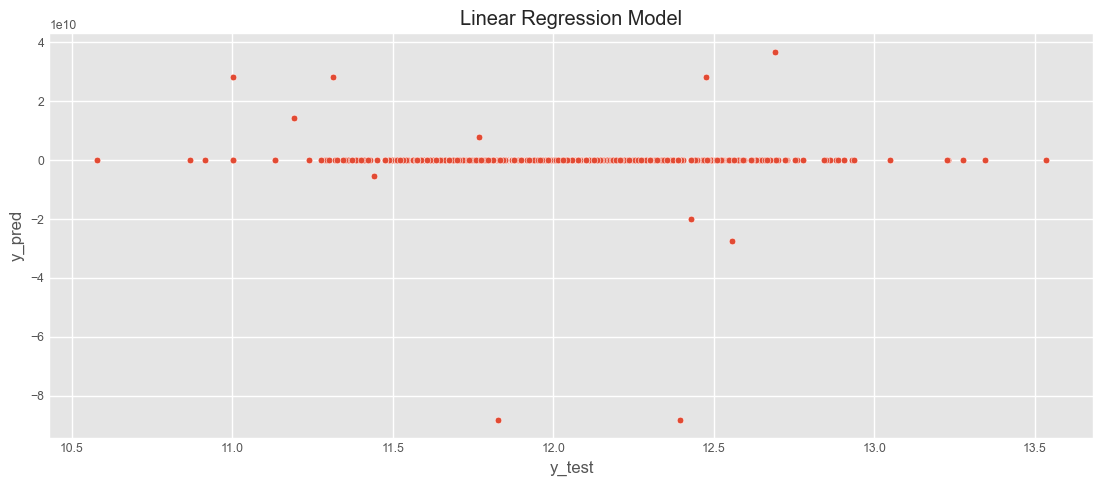

In [196]:
df_lm_pred = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}).set_index(np.arange(0,len(y_test)), len(y_test))

plt.figure(figsize  = (12,5))
sns.scatterplot(x = 'y_test', y = 'y_pred', data = df_lm_pred)
plt.title("Linear Regression Model")
plt.show()

In [197]:
#Other Models Approach( Ridge, Lasso, Elastic Net)

#Ridge
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

alpha_ridge = [-3,-2,-1,1e-15, 1e-10, 1e-8,1e-5,1e-4, 1e-3,1e-2,0.5,1,1.5, 2,3,4, 5, 10, 20, 30, 40]
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    ridge = Ridge(alpha= i, normalize=True)
    ## fit the model. 
    ridge.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    pred_ridge = ridge.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    temp_mse[i] = mse

    

In [198]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

-3: 4.3153615351674135e+19
-2: 4.3153615351674135e+19
-1: 4.3153615351674135e+19
1e-15: 4.3153615351674135e+19
1e-10: 4.3153615351674135e+19
1e-08: 4.3153615351674135e+19
1e-05: 4.3153615351674135e+19
0.0001: 4.3153615351674135e+19
0.001: 4.3153615351674135e+19
0.01: 4.3153615351674135e+19
0.5: 4.3153615351674135e+19
1: 4.3153615351674135e+19
1.5: 4.3153615351674135e+19
2: 4.3153615351674135e+19
3: 4.3153615351674135e+19
4: 4.3153615351674135e+19
5: 4.3153615351674135e+19
10: 4.3153615351674135e+19
20: 4.3153615351674135e+19
30: 4.3153615351674135e+19
40: 4.3153615351674135e+19


In [199]:
#Lasso
from sklearn.linear_model import Lasso 
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    lasso_reg = Lasso(alpha= i, normalize=True)
    ## fit the model. 
    lasso_reg.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    pred_lasso = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    temp_mse[i] = mse

In [200]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

-3: 4.3153615351674135e+19
-2: 4.3153615351674135e+19
-1: 4.3153615351674135e+19
1e-15: 4.3153615351674135e+19
1e-10: 4.3153615351674135e+19
1e-08: 4.3153615351674135e+19
1e-05: 4.3153615351674135e+19
0.0001: 4.3153615351674135e+19
0.001: 4.3153615351674135e+19
0.01: 4.3153615351674135e+19
0.5: 4.3153615351674135e+19
1: 4.3153615351674135e+19
1.5: 4.3153615351674135e+19
2: 4.3153615351674135e+19
3: 4.3153615351674135e+19
4: 4.3153615351674135e+19
5: 4.3153615351674135e+19
10: 4.3153615351674135e+19
20: 4.3153615351674135e+19
30: 4.3153615351674135e+19
40: 4.3153615351674135e+19


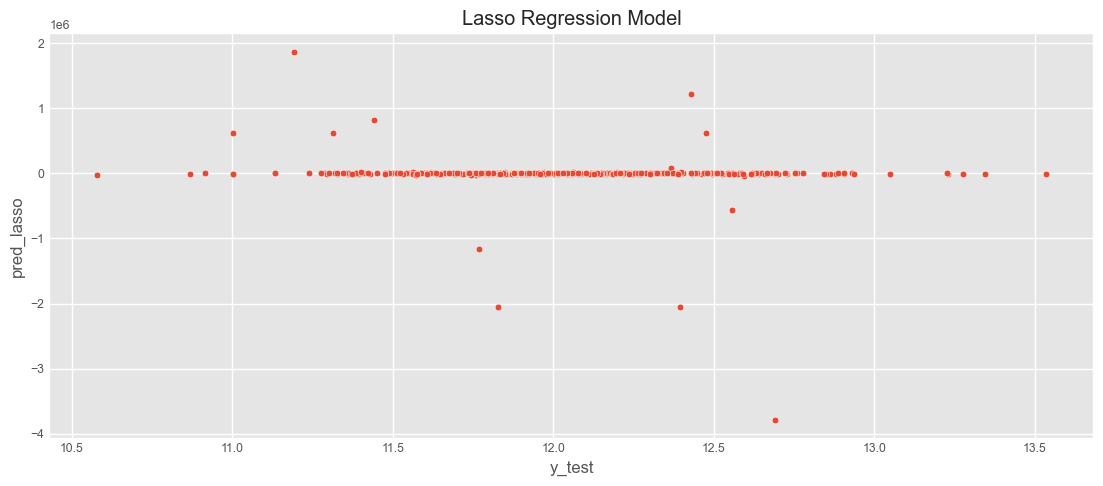

In [201]:
#So the best Lasso Model, in this case, is with alpha = -3
lasso_reg = Lasso(alpha= -3, normalize=True)
lasso_reg.fit(X_train, y_train)
pred_lasso = lasso_reg.predict(X_test)

df_lasso_pred = pd.DataFrame({'y_test': y_test, 'pred_lasso': pred_lasso}).set_index(np.arange(0,len(y_test)), len(y_test))

plt.figure(figsize = (12,5))
sns.scatterplot(x = 'y_test', y = 'pred_lasso', data = df_lasso_pred )
plt.title("Lasso Regression Model")
plt.show()

In [202]:
#Elastic Net
from sklearn.linear_model import ElasticNet
temp_mse = {}
for i in alpha_ridge:
    ## Assigin each model. 
    elastic_reg = ElasticNet(alpha= i, normalize=True)
    ## fit the model. 
    elastic_reg.fit(X_train, y_train)
    ## Predicting the target value based on "Test_x"
    pred_elastic = lasso_reg.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    temp_mse[i] = mse

In [203]:
for key, value in sorted(temp_mse.items(), key=lambda item: item[1]):
    print("%s: %s" % (key, value))

-3: 4.3153615351674135e+19
-2: 4.3153615351674135e+19
-1: 4.3153615351674135e+19
1e-15: 4.3153615351674135e+19
1e-10: 4.3153615351674135e+19
1e-08: 4.3153615351674135e+19
1e-05: 4.3153615351674135e+19
0.0001: 4.3153615351674135e+19
0.001: 4.3153615351674135e+19
0.01: 4.3153615351674135e+19
0.5: 4.3153615351674135e+19
1: 4.3153615351674135e+19
1.5: 4.3153615351674135e+19
2: 4.3153615351674135e+19
3: 4.3153615351674135e+19
4: 4.3153615351674135e+19
5: 4.3153615351674135e+19
10: 4.3153615351674135e+19
20: 4.3153615351674135e+19
30: 4.3153615351674135e+19
40: 4.3153615351674135e+19


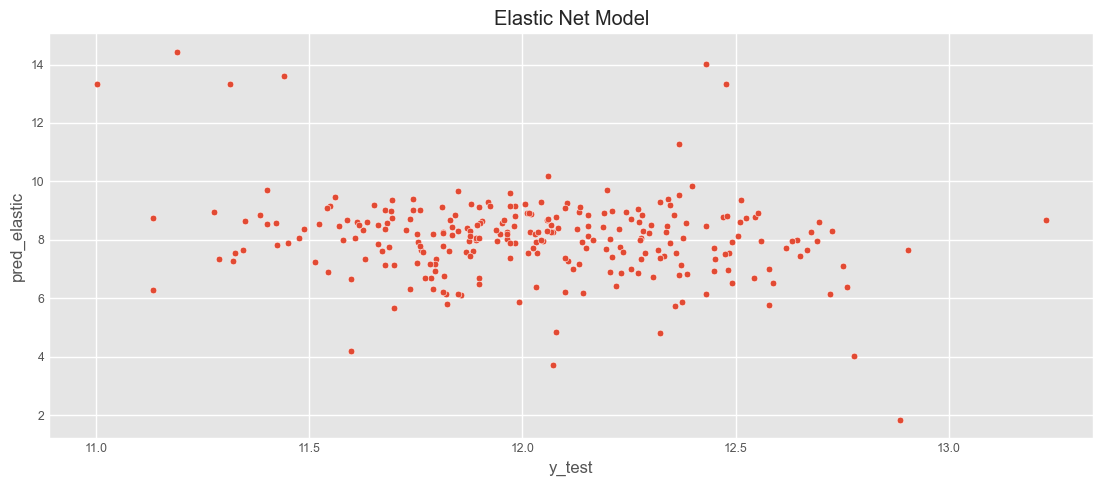

In [204]:
#So the best Elastic Model, in this case, is with alpha = -3
elastic_reg = ElasticNet(alpha= 1, normalize=True)

elastic_reg.fit(X_train, y_train)
## Predicting the target value based on "Test_x"
pred_elastic = lasso_reg.predict(X_test)

df_elastic_pred = pd.DataFrame({'y_test': y_test, 'pred_elastic': np.log(pred_elastic)}).set_index(np.arange(0,len(y_test)), len(y_test))

plt.figure(figsize = (12,5))
sns.scatterplot(x = 'y_test', y = 'pred_elastic', data = df_elastic_pred )
plt.title("Elastic Net Model")
plt.show()

In [205]:
#XGboost
xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

xgboost.fit(X_train, y_train)
pred_xg = xgboost.predict(X_test)                                    

[18:58:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


In [206]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_absolute_error(y_test, pred_xg)

0.08049356080785977

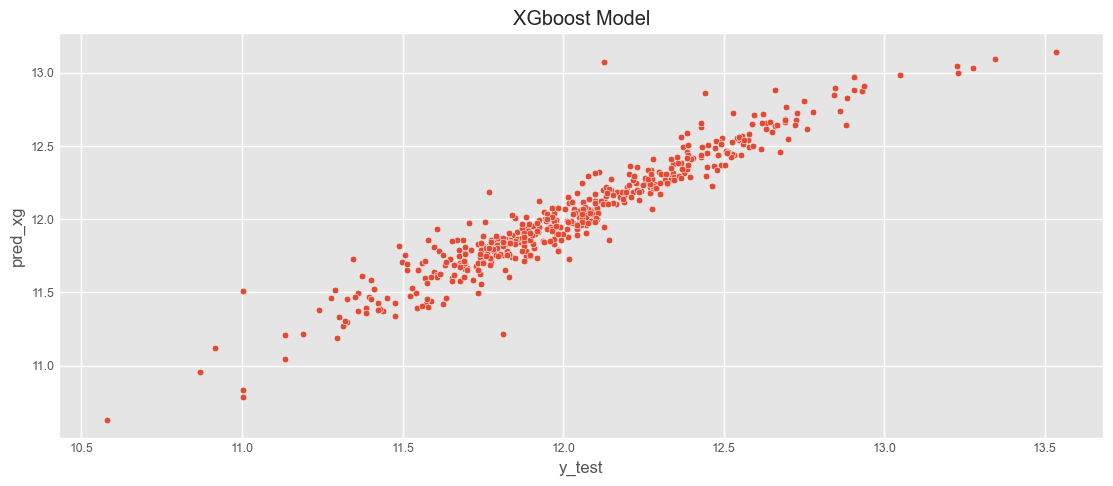

In [207]:
df_xg_pred = pd.DataFrame({'y_test': y_test, 'pred_xg': pred_xg}).set_index(np.arange(0,len(y_test)), len(y_test))

plt.figure(figsize = (12,5))
sns.scatterplot(x = 'y_test', y = 'pred_xg', data = df_xg_pred)
plt.title("XGboost Model")
plt.show()

In [208]:
#LightGBM
lightgbm = lightgbm.LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       )

lightgbm.fit(X_train, y_train)
pred_gbm = lightgbm.predict(X_test)                                       

In [209]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mean_absolute_error(y_test, pred_gbm)

0.08163212245971839

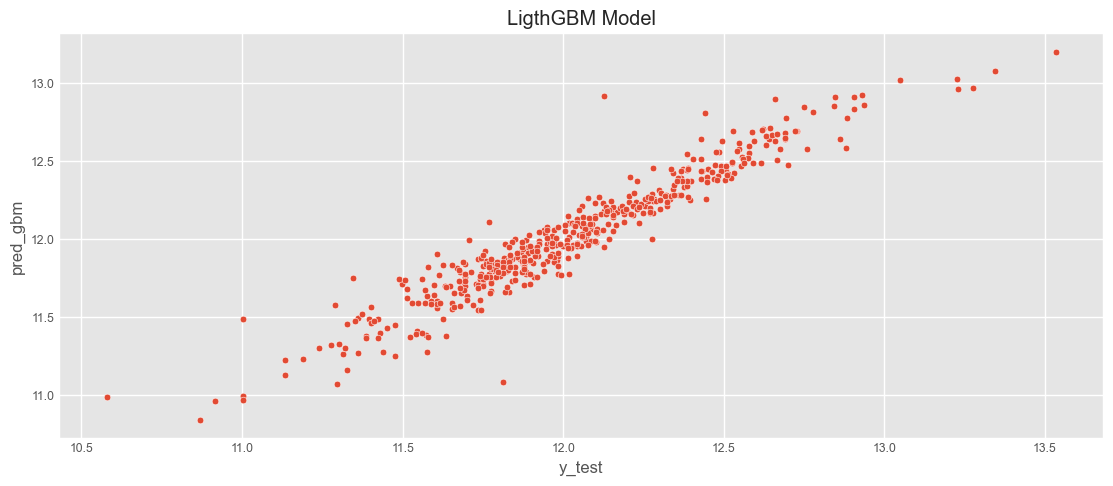

In [210]:
df_gbm_pred = pd.DataFrame({'y_test': y_test, 'pred_gbm': pred_gbm}).set_index(np.arange(0,len(y_test)), len(y_test))

plt.figure(figsize = (12,5))
sns.scatterplot(x = 'y_test', y = 'pred_gbm', data = df_gbm_pred)
plt.title("LigthGBM Model")
plt.show()

In [211]:
#Ensemble party
print('START Fit')

print('elasticnet')
elastic_model_full_data = elastic_reg.fit(X, y)

print('Lasso')
lasso_model_full_data = lasso_reg.fit(X, y)

print('Ridge') 
ridge_model_full_data = ridge.fit(X, y)

print('xgboost')
xgb_model_full_data = xgboost.fit(X, y)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)

START Fit
elasticnet
Lasso
Ridge
xgboost
[18:58:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.
lightgbm


In [212]:
def blend_models_predict(X):
    return ((0.0 * elastic_model_full_data.predict(X)) + \
            (0.0 * lasso_model_full_data.predict(X)) + \
            (0.0 * ridge_model_full_data.predict(X)) + \
            (0.65 * xgb_model_full_data.predict(X)) + \
            (0.35 * lgb_model_full_data.predict(X)))

In [213]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

RMSLE score on train data:
0.05832737503099488


In [214]:
print('Predict submission')
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

Predict submission


In [215]:
submission

,Id,SalePrice
0,1461,124548.0
1,1462,161194.0
2,1463,185146.0
3,1464,191941.0
4,1465,188914.0
...,...,...
1454,2915,79569.0
1455,2916,81756.0
1456,2917,166424.0
1457,2918,116102.0


In [216]:
submission_kaggle = submission.to_csv (r'C:\Users\Tucac\OneDrive\Escritorio\Python Projects\HousePrices\submission_kaggle.csv', 
                                       index = False, header=True)